In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Task 1

Write out the extended Kalman filter (EKF) algorithm for the logistic regression problem described above and present the algorithm as pseudocode. You need to differentiate the logistic function to do this step.

Generate synthetic data from a two-dimensional two-class distinct mean, common covariance problem as outlined in the section above and implement an EKF for the estimation
of its parameters.

Show in a graph how the class boundary converges to the true solution, starting from a random guess.

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap

In [50]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 10,
    # # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [51]:
from numpy.random import default_rng
seed = 42
rng = default_rng(seed=42)

In [52]:
def generate_data(alpha, cov, N, random_state=42):
    mean0 = [-alpha, alpha]
    mean1 = [alpha, -alpha]
    
    X0 = rng.multivariate_normal(mean0, cov, int(N/2))
    X1 = rng.multivariate_normal(mean1, cov, int(N/2))

    X = np.concatenate([X0, X1])
    y = np.concatenate([np.zeros(int(N/2)), np.ones(int(N/2))])

    X, y = shuffle(X, y, random_state=random_state)

    return X, y

In [53]:
N = 1000
alpha = [0.5, 2]
cov = [[2, 1], [1, 2]]

X0, y0 = generate_data(alpha[0], cov, N, random_state=seed)
X1, y1 = generate_data(alpha[1], cov, N, random_state=seed)

Text(0.5, 0.98, 'Binary Classification Synthetic Dataset')

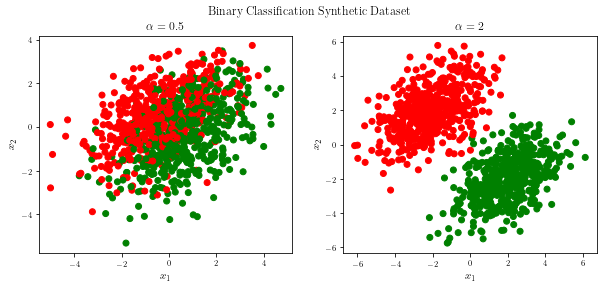

In [179]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
colors = ['red', 'green']
ax[0].scatter(X0[:, 0], X0[:, 1], c=y0, label=r"$\alpha = 0.5$", cmap=ListedColormap(colors))
ax[1].scatter(X1[:, 0], X1[:, 1], c=y1, label=r"$\alpha = 2$", cmap=ListedColormap(colors))
ax[0].set(title=r"$\alpha = 0.5$", xlabel="$x_1$", ylabel="$x_2$")
ax[1].set(title=r"$\alpha = 2$", xlabel="$x_1$", ylabel="$x_2$")
fig.suptitle("Binary Classification Synthetic Dataset")

In [180]:
# fig.savefig("report/Figures/dataset.pdf")

In [55]:
from pf import EKF_LR, PF_LR, sigmoid

In [56]:
Ns = 100
theta0 = rng.random(2)
P0 = 0.001 * np.eye(2)
beta = 0.01
Q = beta * np.eye(2) # process noise
R = [np.var(X0), np.var(X1)] # observation noise

## EKF

In [133]:
theta_ekf_0, P_ekf_0, error_ekf_0 = EKF_LR(X0, y0, theta0, P0, Q, R[0])
theta_ekf_1, P_ekf_1, error_ekf_1 = EKF_LR(X1, y1, theta0, P0, Q, R[1])
error_ekf_0 = error_ekf_0**2
error_ekf_1 = error_ekf_1**2

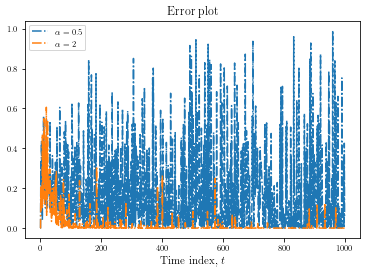

In [134]:
fig, ax = plt.subplots()
ax.set(title='Error plot', xlabel='Time index, $t$')
ax.plot(error_ekf_0, linestyle='-.', label=r"$\alpha = 0.5$")
ax.plot(error_ekf_1, linestyle='-.', label=r"$\alpha = 2$")
ax.legend()

In [135]:
# fig.savefig('report/Figures/error_lr.pdf')

In [142]:
argmin_ekf_0 = np.argmin(error_ekf_0[2:])
theta_min_ekf_0 = theta_ekf_0[argmin_ekf_0]

argmin_ekf_1 = np.argmin(error_ekf_1[2:])
theta_min_ekf_1 = theta_ekf_1[argmin_ekf_1]

In [143]:
def accuracy(X, y, theta):
    preds = sigmoid(X @ theta)
    msk = preds >= 0.5
    preds[msk] = 1
    preds[~msk] = 0
    bincount = np.bincount((preds == y))
    acc = bincount[1] / X.shape[0]
    return acc

In [144]:
acc_ekf_0 = accuracy(X0, y0, theta_min_ekf_0)
acc_ekf_1 = accuracy(X1, y1, theta_min_ekf_1)

In [145]:
acc_ekf_0

0.762

In [146]:
acc_ekf_1

0.998

## PF

In [252]:
theta_sir, weights_sir, error_sir, ess_sir = PF_LR(X, y, theta0, Q, R, Ns, resample=True)

100%|██████████| 998/998 [00:25<00:00, 38.91it/s]


In [253]:
theta_sir_expected = np.sum(weights_sir[:, :, np.newaxis] * theta_sir, axis=1)

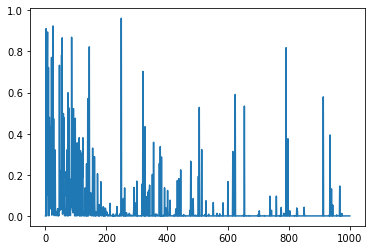

In [254]:
plt.plot(error_sir**2)

In [260]:
argmin_sir = np.argmin(error_sir)
theta_min_sir = theta_sir_expected[argmin_sir]

In [261]:
preds_pf = sigmoid(X @ theta_min_sir)
preds_pf[preds_pf >= 0.5] = 1
preds_pf[preds_pf < 0.5] = 0
bincount_pf = np.bincount((preds_pf == y))

In [262]:
acc_pf = bincount[1] / N

In [263]:
acc

0.994